In [25]:
from joblib import dump, load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import string
from collections import Counter

In [26]:
TFIDFEmbedding = load("TFIDFEmbedding.joblib")
KNNModel = load("KNNModel.joblib")

sbert = load("sbert.joblib")
faiss = load("faiss.joblib")

bm25 = load("bm25.joblib")

df = pd.read_csv("synthetic_names_samples.csv")
docs = df['transcription'].tolist()

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Neares

In [27]:
questions = []
answers = []

questions.append("What is Charlie Harlow's dosage?")
answers.append(0)

questions.append("What is the age of the patient with name Jenna Lundsten and has bladder cancer?")
answers.append(113)

questions.append("What was the procedure done for Richard Jasso, who had heavy tobacco abuse?")
answers.append(793)

questions.append("How did we obtain consent for surgery for Dorothy Robinson?")
answers.append(818)

questions.append("What is the procedure performed on the 55 year old female who is having a colonoscopy to screen for colon cancer?")
answers.append(976)

questions.append("What happened to the Michael Dunstan who takes hydrochlorothiazide for hypertension?")
answers.append(13)

questions.append("What is the operation done on Michael Neal?")
answers.append(1162)

questions.append("What is the medication given to Karen Lewis?")
answers.append(1449)

questions.append("What is the impression on Adam Juarez who took an MRI?")
answers.append(1546)

questions.append("What were the symptoms on Jason Olguin who was given amphotericin?")
answers.append(1593)


In [28]:
knn_answers = []
faiss_answers = []
bm25_answers = []

sbert.tokenizer.pad_token = "[UNK]"
sbert.tokenizer.pad_token_id = sbert.tokenizer.convert_tokens_to_ids("[UNK]")
for question in questions: 
    # TFIDF + KNN
    tfidf = TFIDFEmbedding.transform([question])
    knn_ans = KNNModel.kneighbors(tfidf , return_distance=False)
    knn_answers.append(knn_ans)

    # SBERT + FAISS
    sbert_embedding = sbert.encode([question]).astype('float32')
    dustabces, indices = faiss.search(sbert_embedding , 10)
    faiss_answers.append(indices)

    # BM25
    bm_tokens = question.lower().split()
    bm_scores = np.argsort(bm25.get_scores(bm_tokens))[::-1][:10]
    bm25_answers.append(bm_scores)

In [29]:
# Accuracy scores:
faiss_accuracy = 0
bm25_accuracy = 0
knn_accuracy = 0

faiss_inverse = 0
bm25_inverse = 0
knn_inverse = 0

for i in range(0, 10, 1):
    if(answers[i] in knn_answers[i]):
        knn_accuracy+=1
        knn_index = knn_answers[i].tolist()[0].index(answers[i]) + 1
        knn_inverse += (1/knn_index)
    if(answers[i] in faiss_answers[i]):
        faiss_accuracy+=1
        faiss_index = faiss_answers[i].tolist()[0].index(answers[i]) + 1
        faiss_inverse += (1/faiss_index)
    if(answers[i] in bm25_answers[i]):
        bm25_accuracy+=1
        bm_index = bm25_answers[i].tolist().index(answers[i]) + 1
        bm25_inverse += (1/bm_index)

In [30]:
knn_mrr = knn_inverse / len(answers)
faiss_mrr = faiss_inverse / len(answers)
bm25_mrr = bm25_inverse / len(answers)

In [31]:
print("knn mrr : " , knn_mrr)
print("faiss mrr : " , faiss_mrr)
print("bm25 mrr : " , bm25_mrr)

knn mrr :  0.35
faiss mrr :  0.4444444444444445
bm25 mrr :  0.5833333333333333


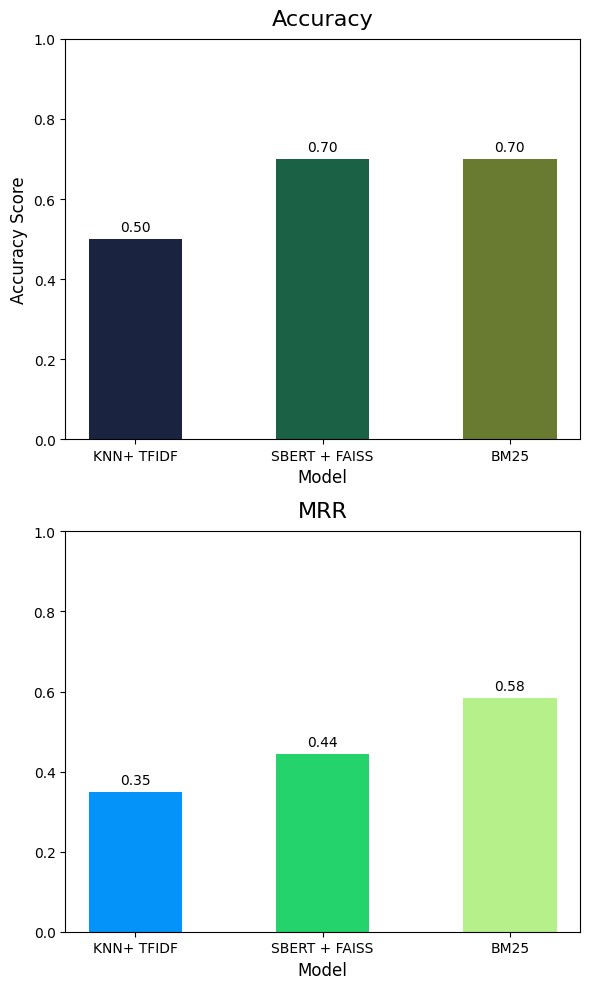

In [32]:
models = ['KNN+ TFIDF', 'SBERT + FAISS', 'BM25']
accuracy_scores = [knn_accuracy / 10, faiss_accuracy / 10, bm25_accuracy / 10]

mrr_scores = [knn_mrr , faiss_mrr , bm25_mrr]

fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharey=True)  # 1 row, 2 columns

# Test 1 plot
axes[0].bar(models, accuracy_scores, color = sns.color_palette('cubehelix'), width = 0.5)
axes[0].set_title('Accuracy', fontsize=16, pad=10)
axes[0].set_ylabel('Accuracy Score', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
for i, score in enumerate(accuracy_scores):
    axes[0].text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

# Test 2 plot
axes[1].bar(models, mrr_scores, color = sns.color_palette('terrain'), width = 0.5)
axes[1].set_title('MRR', fontsize=16, pad=10)
axes[1].set_xlabel('Model', fontsize=12)
for i, score in enumerate(mrr_scores):
    axes[1].text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [33]:
# Tests for part 2 of the model : Question Answering

In [34]:
qa_model_name = "dmis-lab/biobert-large-cased-v1.1-squad"
tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name)
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

Device set to use cpu


In [35]:
questions = []
documents = []

questions.append("What is Charlie Harlow's dosage?")
documents.append(docs[0])

questions.append("What is the age of the patient with name Jenna Lundsten and has bladder cancer?")
documents.append(docs[113])

questions.append("What was the procedure done for Richard Jasso, who had heavy tobacco abuse?")
documents.append(docs[793])

questions.append("How did we obtain consent for surgery for Dorothy Robinson?")
documents.append(docs[818])

questions.append("What is the procedure performed on the 55 year old female who is having a colonoscopy to screen for colon cancer?")
documents.append(docs[976])

questions.append("What happened to the Michael Dunstan who takes hydrochlorothiazide for hypertension?")
documents.append(docs[13])

questions.append("What is the operation done on Michael Neal?")
documents.append(docs[1162])

questions.append("What is the medication given to Karen Lewis?")
documents.append(docs[1449])

questions.append("What is the impression on Adam Juarez who took an MRI?")
documents.append(docs[1546])

questions.append("What were the symptoms on Jason Olguin who was given amphotericin?")
documents.append(docs[1593])

In [36]:
docs[1593]

"NAME : Jason Olguin  CC: ,Headache.,HX: ,This 37y/o LHM was seen one month prior to this presentation for HA, nausea and vomiting. Gastrointestinal evaluation at that time showed no evidence of bowel obstruction and he was released home. These symptoms had been recurrent since onset.,At presentation he complained of mild blurred vision (OU), difficulty concentrating and HA which worsened upon sitting up. The headaches were especially noticeable in the early morning. He described them as non-throbbing headaches. They begin in the bifrontal region and radiate posteriorly. They occurred up to 6 times/day. The HA improved with lying down or dropping the head down between the knees towards the floor. The headaches were associated with blurred vision, nausea,vomiting, photophobia, and phonophobia. He denied any scotomata or positive visual phenomena. He denies any weakness, numbness, tingling, dysarthria or diplopia. His weight has fluctuated from 163# to 148# over the past 3 months and at 

In [37]:
ground_truths = ["Samples of Nasonex two sprays in each nostril given for three weeks.", "66-year-old"
                 , "Right common femoral artery cannulation", "After risk of operation was explained to this patient's family"
                 , "The tip of the endoscope was introduced into the rectum."
                 , "a hysterectomy done in 2000 and a gallbladder resection"
                 , " Bilateral Myringotomy with placement of PE tubes"
                 , "Ativan"
                 , "mild degenerative"
                 , "HA, nausea and vomiting"]

In [38]:
predictions = []
for i in range(len(questions)):
    prediction = qa_pipeline({'question': questions[i], 'context': documents[i]})
    predictions.append(prediction['answer'])

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


In [39]:
predictions

['Ortho Tri-Cyclen and the Allegra',
 '66-year-old',
 'Right common femoral artery cannulation',
 "After risk of operation was explained to this patient's family",
 'Colonoscopy',
 'a hysterectomy done in 2000 and a gallbladder resection',
 'Bilateral Myringotomy with placement of PE tubes',
 'Ativan',
 'mild degenerative',
 'HA, nausea and vomiting']

In [40]:
def normalize_text(s):
    def remove_articles(text):
        return ' '.join([word for word in text.split() if word not in ('a', 'an', 'the')])
    
    def remove_punctuation(text):
        return ''.join([char for char in text if char not in string.punctuation])
    
    def to_lower(text):
        return text.lower()
    
    return remove_articles(remove_punctuation(to_lower(s))).strip()

def compute_f1(prediction, ground_truth):
    prediction_tokens = normalize_text(prediction).split()
    ground_truth_tokens = normalize_text(ground_truth).split()
    
    common_tokens = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    number_of_matches = sum(common_tokens.values())
    
    if len(prediction_tokens) == 0 or len(ground_truth_tokens) == 0:
        return 0
    
    if number_of_matches== 0:
        return 0
    
    precision = number_of_matches / len(prediction_tokens)
    recall = number_of_matches / len(ground_truth_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

def compute_average_f1(predictions, ground_truths):
    assert len(predictions) == len(ground_truths), "Number of predictions and ground truths must match."
    f1_scores = [compute_f1(prediction, ground_truth) for prediction, ground_truth in zip(predictions, ground_truths)]
    average_f1 = sum(f1_scores) / len(f1_scores)
    return average_f1


In [41]:
print("F1 Score: " + str(compute_average_f1(predictions, ground_truths)))

F1 Score: 0.8
